In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors
from dateutil import parser

# Import Scikit-learn for Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE

In [ ]:
df = pd.read_csv("df_arabica_clean.csv")
df.head()

,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,...,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,NaN,Coffee Quality Union,1700-1930,"Piendamo,Cauca",...,89.33,11.8,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,NaN,Taiwan Coffee Laboratory,1200,Chiayi,...,87.58,10.5,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,NaN,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,...,87.42,10.4,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,NaN,Coffee Quality Union,1900,"Los Santos,Tarrazu",...,87.17,11.8,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,NaN,Coffee Quality Union,1850-2100,"Popayan,Cauca",...,87.08,11.6,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901


In [ ]:
# Handle duplicates
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (0, 41)


In [ ]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Unnamed: 0: 207 distinct values
ID: 207 distinct values
Country of Origin: 22 distinct values
Farm Name: 173 distinct values
Lot Number: 188 distinct values
Mill: 163 distinct values
ICO Number: 68 distinct values
Company: 72 distinct values
Altitude: 98 distinct values
Region: 121 distinct values
Producer: 173 distinct values
Number of Bags: 55 distinct values
Bag Weight: 39 distinct values
In-Country Partner: 21 distinct values
Harvest Year: 7 distinct values
Grading Date: 75 distinct values
Owner: 80 distinct values
Variety: 49 distinct values
Status: 1 distinct values
Processing Method: 11 distinct values
Aroma: 19 distinct values
Flavor: 19 distinct values
Aftertaste: 20 distinct values
Acidity: 19 distinct values
Body: 17 distinct values
Balance: 18 distinct values
Uniformity: 3 distinct values
Clean Cup: 1 distinct values
Sweetness: 1 distinct values
Overall: 21 distinct values
Defects: 1 distinct values
Total Cup Points: 81 distinct values
Moisture Percentage: 46 distinct value

In [ ]:
#check missing ratio
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

,Missing Ratio
ICO Number,63.768116
Variety,2.898551
Processing Method,2.415459
Mill,1.449275
Farm Name,0.966184
Region,0.966184
Lot Number,0.483092
Altitude,0.483092
Producer,0.483092


In [ ]:
# Mapping
processing_mapping = {
    "Double Anaerobic Washed": "Washed / Wet",
    "Semi Washed": "Washed / Wet",
    "Honey,Mossto": "Pulped natural / honey",
    "Double Carbonic Maceration / Natural": "Natural / Dry",
    "Wet Hulling": "Washed / Wet",
    "Anaerobico 1000h": "Washed / Wet",
    "SEMI-LAVADO": "Natural / Dry"
}
# Fixing the values in the column
df['Processing Method'] = df['Processing Method'].map(processing_mapping)
df['Processing Method'].fillna("Washed / Wet", inplace=True)

In [ ]:
# Manually impute specific values based on ID (Which we cant use function)
df.loc[df['ID'] == 99, 'Altitude'] = 5273  # Impute value for ID 99
df.loc[df['ID'] == 105, 'Altitude'] = 1800  # Impute value for ID 105
df.loc[df['ID'] == 180, 'Altitude'] = 1400  # Impute value for ID 180


# Define a function to clean and calculate the mean
def clean_altitude_range(range_value):
    if isinstance(range_value, str):
        range_value = range_value.replace(" ", "")  # Remove blank spaces
        if '-' in range_value:
            try:
                start, end = range_value.split('-')
                start = int(start)
                end = int(end)
                return (start + end) / 2
            except ValueError:
                return np.nan
        else:
            try:
                return int(range_value)
            except ValueError:
                return np.nan
    else:
        return range_value

# Apply the function to clean and calculate the mean for each value in the "Altitude" column
df['Altitude'] = df['Altitude'].apply(clean_altitude_range)

In [ ]:
# Extract the prior year from the "Harvest Year" column
df['Harvest Year'] = df['Harvest Year'].str.split('/').str[0].str.strip()

#Feature Engineering

In [ ]:
# Convert "Harvest Year" and "Expiration" columns to datetime objects using dateutil parser
df['Harvest Year'] = pd.to_datetime(df['Harvest Year'], format='%Y')
df['Expiration'] = df['Expiration'].apply(parser.parse)

In [ ]:
# Calculate the difference in days between "Expiration" and "Harvest Year" columns
df['Coffee Age'] = (df['Expiration'] - df['Harvest Year']).dt.days

In [ ]:
columns_to_drop = ['ID','ICO Number','Owner','Region','Certification Contact','Certification Address','Farm Name',"Lot Number","Mill","ICO Number","Producer",'Company','Expiration', 'Harvest Year',
                   "Unnamed: 0",'Number of Bags','Bag Weight','In-Country Partner','Grading Date','Variety','Status','Defects','Uniformity','Clean Cup','Sweetness','Certification Body']
df.drop(columns_to_drop, axis=1, inplace=True)

#EDA

<Figure size 1200x1000 with 0 Axes>

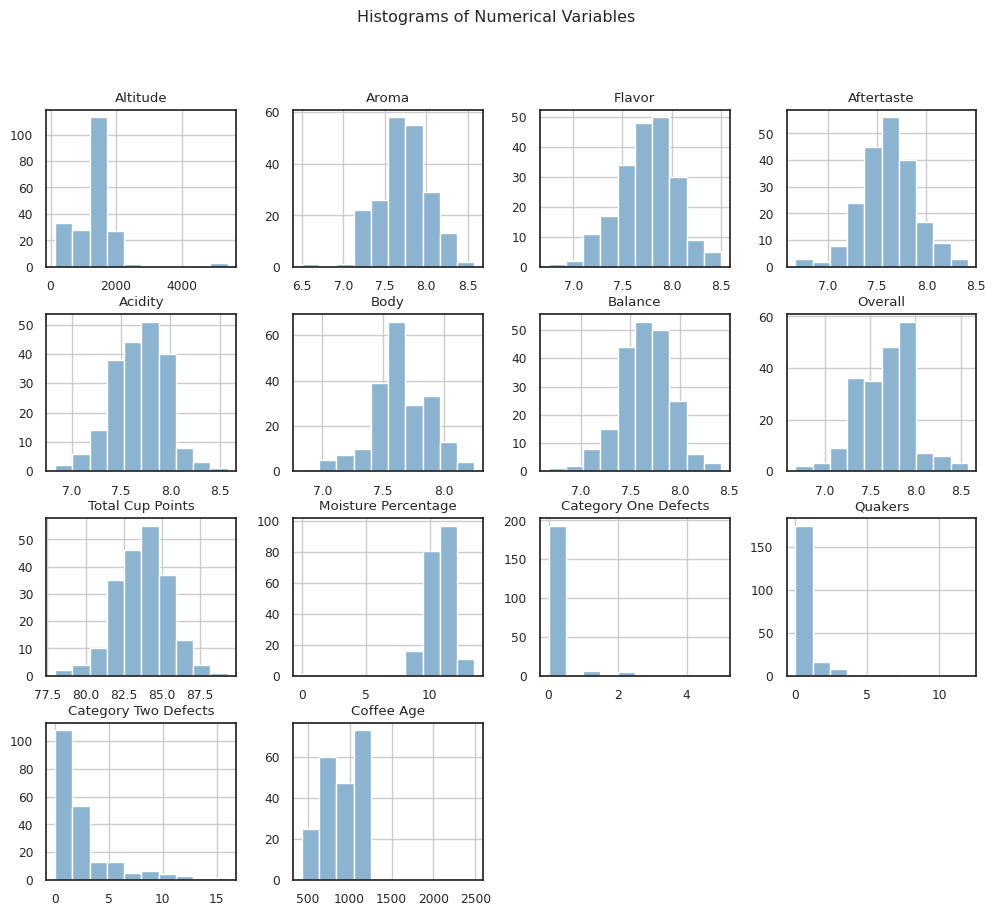

In [ ]:
# @title Histograms of Numerical Variables
plt.figure(figsize=(12, 10))
df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

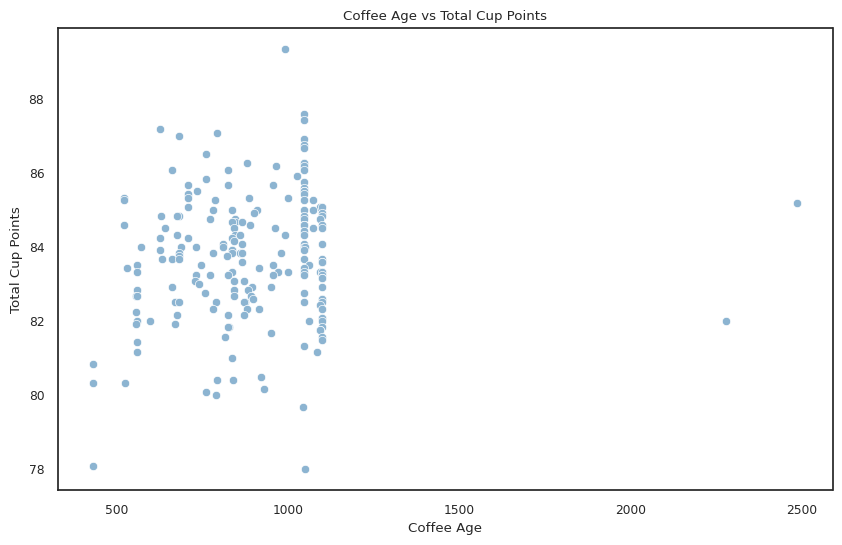

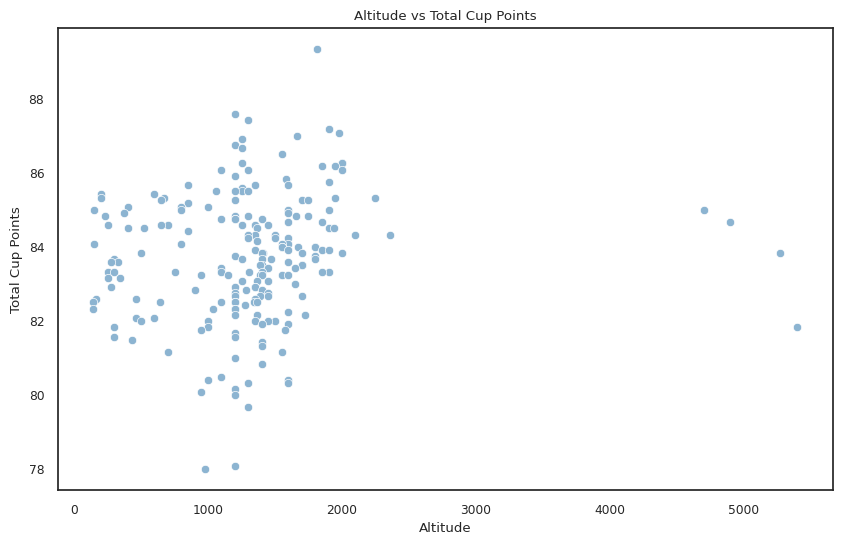

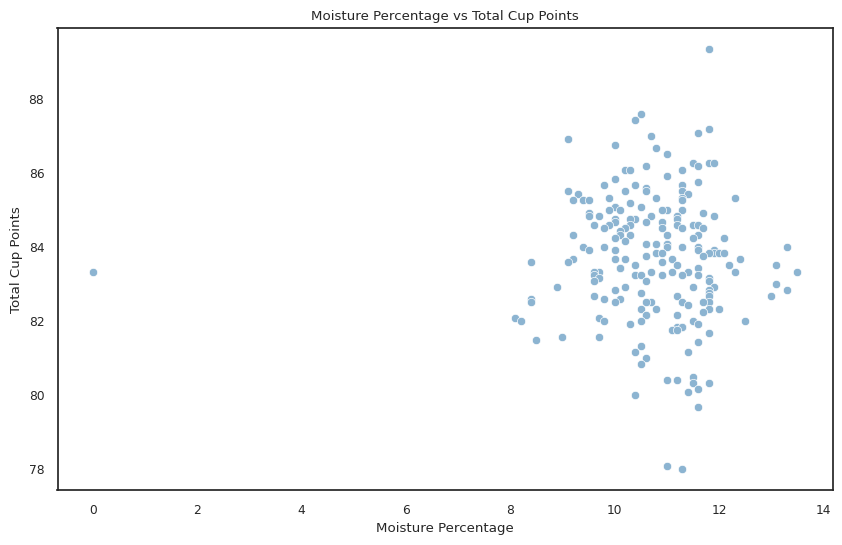

In [ ]:
# Select numerical columns to plot against 'Total Cup Points'
numerical_columns = [ 'Coffee Age', 'Altitude', 'Moisture Percentage']

# Loop through each numerical column to create scatter plots
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=column, y='Total Cup Points', data=df)
    plt.title(f'{column} vs Total Cup Points')
    plt.xlabel(column)
    plt.ylabel('Total Cup Points')
    plt.show()

#Correlation

In [ ]:
data = df.copy()
categorical_columns = ['Processing Method']
numerical_columns = ['Altitude', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall', 'Total Cup Points', 'Moisture Percentage', 'Category One Defects', 'Quakers', 'Category Two Defects', 'Coffee Age']
columns_to_drop = ['Country of Origin', 'Color']
data.drop(columns_to_drop, axis=1, inplace=True)
dummy_variables = pd.get_dummies(data, columns=categorical_columns, drop_first=False)

In [ ]:
scaler = StandardScaler()

# Scale the numerical columns
scaled_numerical = scaler.fit_transform(data[numerical_columns])

# Convert the scaled numerical columns
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

In [ ]:
# Drop the original numerical columns
dummy_variables = dummy_variables.drop(numerical_columns, axis=1)

# Concatenate the dummy variables and scaled numerical columns
processed_df = pd.concat([dummy_variables, scaled_numerical_df], axis=1)

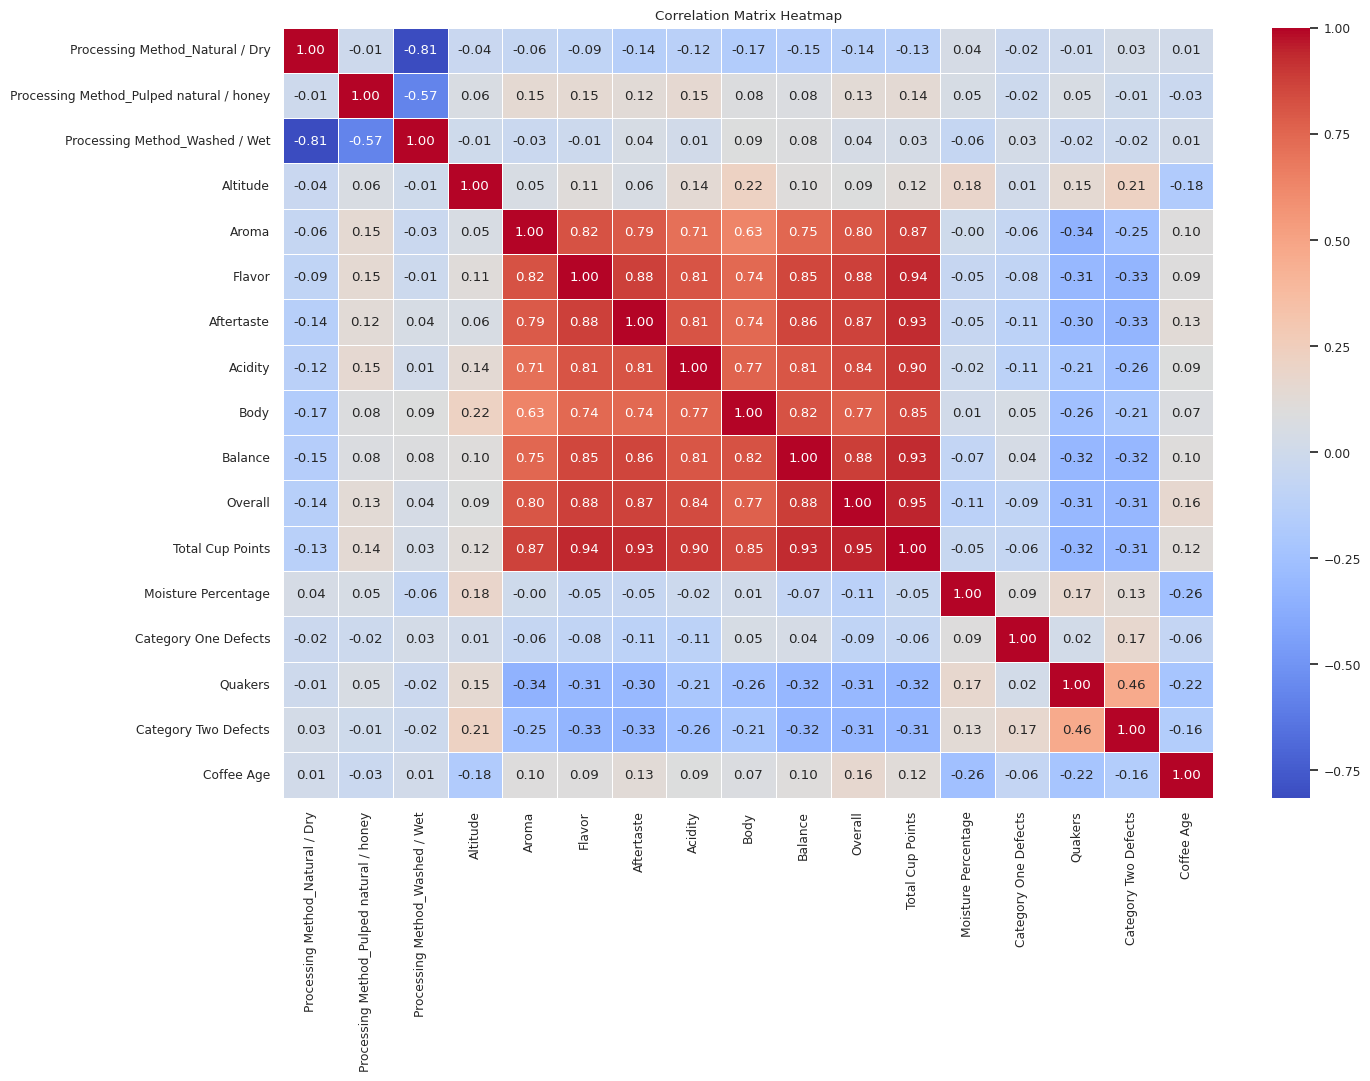

In [ ]:
correlation_matrix = processed_df.corr()

#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()



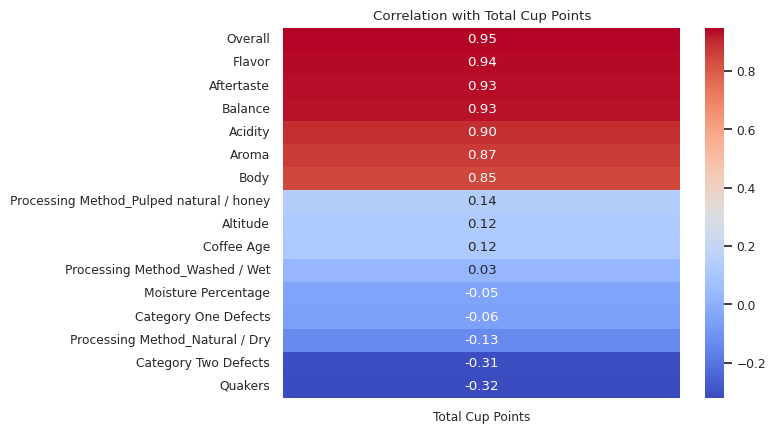

In [ ]:
corr = processed_df.corr()
target_corr = corr['Total Cup Points'].drop('Total Cup Points')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

#Graph II
# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Total Cup Points')
plt.show()

In [ ]:
# Create a copy of the dataframe to not alter the original
df_preprocessed = df.copy()

# Preprocessing: Label encoding for categorical variables
le = LabelEncoder()
categorical_features = ['Country of Origin', 'Processing Method', 'Color']
for feature in categorical_features:
    df_preprocessed[feature] = le.fit_transform(df[feature])

# Preprocessing: MinMax scaling for numerical/ratio variables
mm = MinMaxScaler()
numerical_features = ['Altitude', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall', 'Total Cup Points', 'Moisture Percentage', 'Category One Defects', 'Quakers', 'Category Two Defects', 'Coffee Age']
for feature in numerical_features:
    df_preprocessed[feature] = mm.fit_transform(df[feature].values.reshape(-1,1))

# Apply t-SNE with different perplexity and learning rate
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
tsne_results = tsne.fit_transform(df_preprocessed)

# Plotly Interactive plot
df_tsne = pd.DataFrame(data = tsne_results, columns = ['Dim_1', 'Dim_2'])
df_tsne['Total Cup Points'] = df['Total Cup Points']
fig = px.scatter(df_tsne, x='Dim_1', y='Dim_2', color='Total Cup Points', title='t-SNE plot colored by Total Cup Points')
fig.show()

In [ ]:
df.head()

,Country of Origin,Altitude,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Overall,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Coffee Age
0,Colombia,1815.0,Washed / Wet,8.58,8.50,8.42,8.58,8.25,8.42,8.58,89.33,11.8,0,0,green,3,993
1,Taiwan,1200.0,Washed / Wet,8.50,8.50,7.92,8.00,7.92,8.25,8.50,87.58,10.5,0,0,blue-green,0,1048
2,Laos,1300.0,Washed / Wet,8.33,8.42,8.08,8.17,7.92,8.17,8.33,87.42,10.4,0,0,yellowish,2,1048
3,Costa Rica,1900.0,Washed / Wet,8.08,8.17,8.17,8.25,8.17,8.08,8.25,87.17,11.8,0,0,green,0,628
4,Colombia,1975.0,Pulped natural / honey,8.33,8.33,8.08,8.25,7.92,7.92,8.25,87.08,11.6,0,2,yellow-green,2,794


In [ ]:
categorical_columns = ['Processing Method','Country of Origin', 'Color']
numerical_columns = ['Altitude', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall', 'Total Cup Points', 'Moisture Percentage', 'Category One Defects', 'Quakers', 'Category Two Defects', 'Coffee Age']

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), [col for col in numerical_columns if col != 'Total Cup Points']),
        ('cat', OneHotEncoder(), categorical_columns)])

# Append classifier to preprocessing pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split the data into train and test sets
X = df.drop('Total Cup Points', axis=1)
y = df['Total Cup Points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.12759811833333123


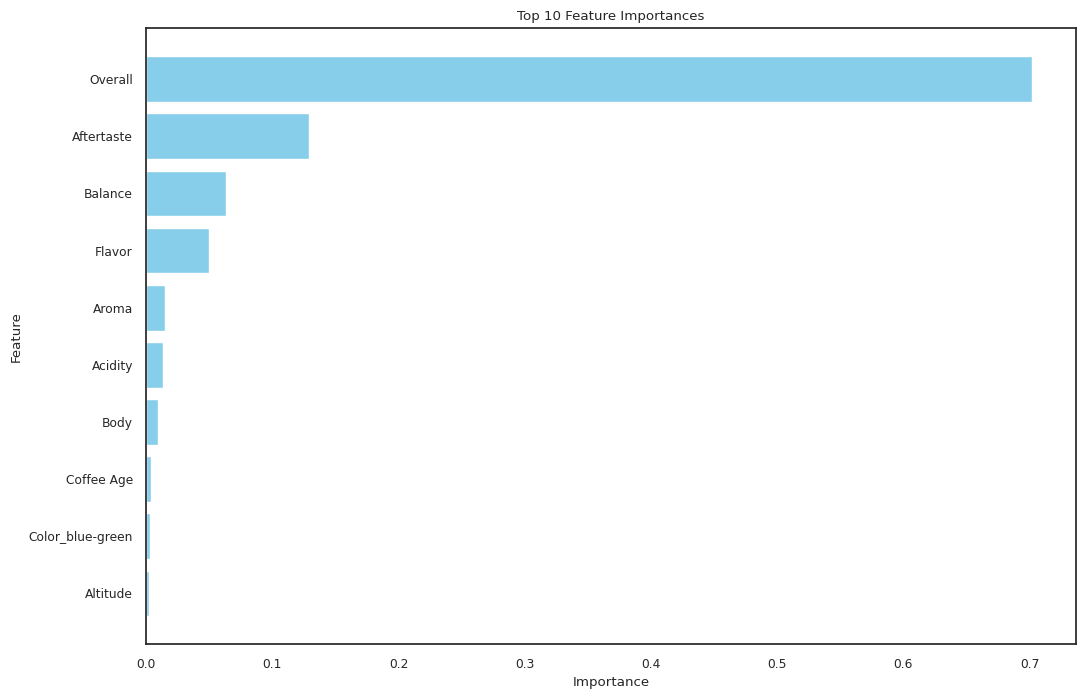

In [ ]:
# Get feature importances
feature_importances = clf.named_steps['classifier'].feature_importances_

# Get feature names from numerical columns
num_feature_names = numerical_columns

# Get feature names from categorical columns after one-hot encoding
cat_feature_names = clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns).tolist()

# Combine numerical and categorical feature names
all_feature_names = num_feature_names + cat_feature_names

# Remove 'Total Cup Points' from all_feature_names
all_feature_names.remove('Total Cup Points')

importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Select top 10 features
top_10_importances = importances_df.head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_10_importances['Feature'], top_10_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [ ]:
# Check the lengths of the categorical and numerical feature names
print("Number of numerical feature names:", len(num_feature_names))
print("Number of categorical feature names:", len(cat_feature_names))


Number of numerical feature names: 14
Number of categorical feature names: 35


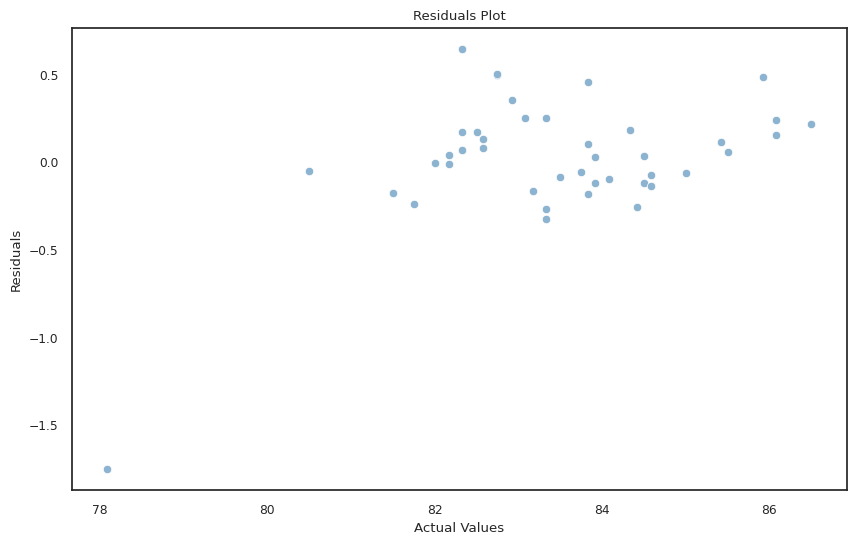

In [ ]:
# Plot residuals
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_test, y=residuals)
plt.title('Residuals Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

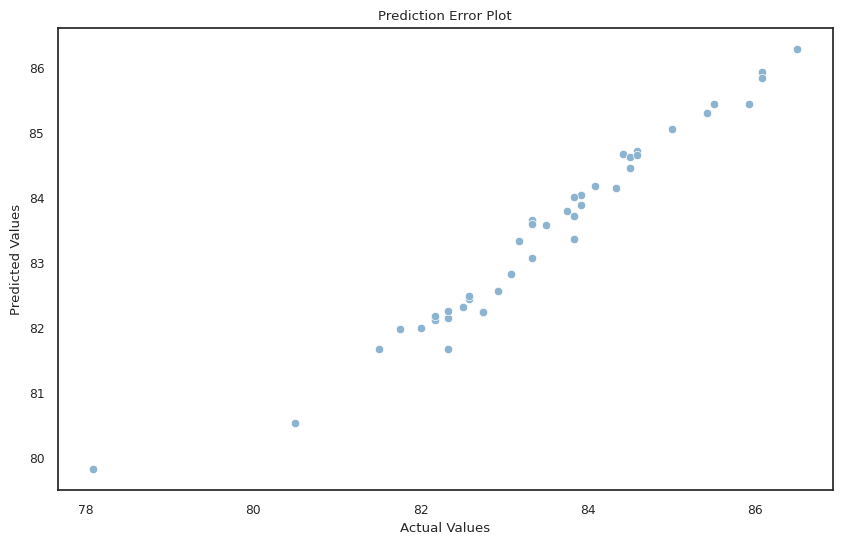

In [ ]:
# Plot prediction error
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Prediction Error Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()